# Graph reconstruction in 3d 

In 3d there is no implemented filtered Back projection, hence we accomodate it 
by structuring the ECT to make the FBP easier. 
 


In [74]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import torchvision.transforms.functional as f

np.random.seed(42)

NUM_STEPS=512

def generate_thetas():
    v = []
    for theta in torch.linspace(0,torch.pi,8):
        for phi in torch.linspace(0,torch.pi,64):
            v.append(
                torch.tensor([
                    torch.sin(phi)*torch.cos(theta),
                    torch.sin(phi)*torch.sin(theta),
                    torch.cos(phi)
                ])
                )
    return torch.vstack(v).T

v = generate_thetas()

In [75]:
scale = 500
def compute_ect(x, v, ei=None):
    nh = x @ v
    lin = torch.linspace(-1, 1, NUM_STEPS).view(-1, 1, 1)
    ecc =  torch.nn.functional.sigmoid(scale * torch.sub(lin, nh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, nh)))
    ecc = ecc.sum(axis=1)
    if ei is not None:
        eh = nh[ei].mean(axis=0)
        eccedge = torch.nn.functional.sigmoid(scale * torch.sub(lin, eh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, eh)))
        eccedge = eccedge.sum(axis=1)
        ecc -= eccedge
    return ecc



In [76]:
from datasets.tu import TUDataModule,TUBZRConfig
from datasets.transforms import CenterTransform

dataset = TUDataModule(TUBZRConfig())

data = dataset.entire_ds[16]
data.x = data.x[:,:3]

ct = CenterTransform()
data = ct(data)

ei = data.edge_index
x = data.x
print(ei.shape)
print(x.shape)


torch.Size([2, 70])
torch.Size([33, 3])


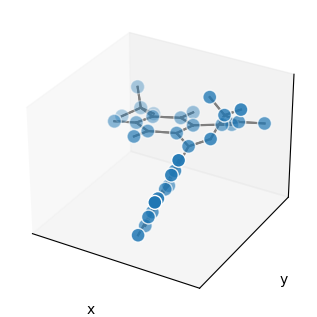

In [77]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The graph to visualize
# G = nx.cycle_graph(20)
# pos = nx.spring_layout(G, dim=3, seed=779)

# 3d spring layout
# Extract node and edge positions from the layout
node_xyz = data.x.numpy()
pts = data.x.numpy()

edge_xyz = np.array([(pts[u], pts[v]) for u, v in data.edge_index.T])


# node_xyz = pts
# edge_xyz = np.array(ei_recon).T

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(121, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()

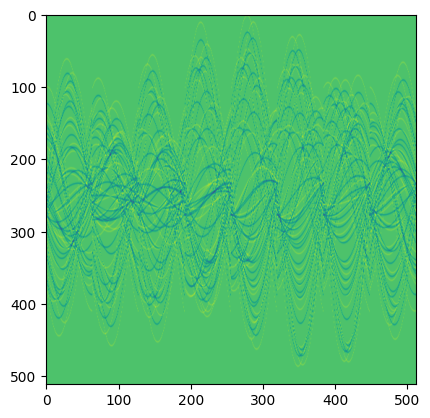

In [78]:

ect = compute_ect(data.x,v,ei=data.edge_index)

ect.shape
plt.imshow(ect)

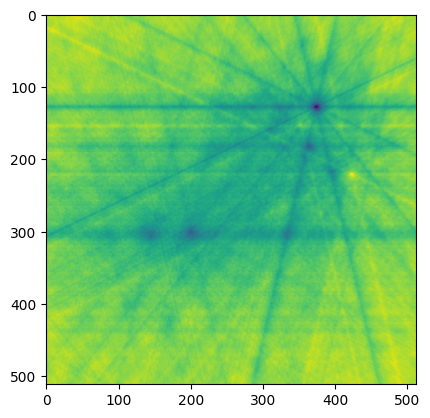

In [79]:
# ####################################################
# ### Reconstruct 3d using filtered backprojection.
# ####################################################

xg, yg ,zg = np.meshgrid(np.linspace(-1,1,NUM_STEPS,endpoint=False),np.linspace(-1,1,NUM_STEPS,endpoint=False),np.linspace(-1,1,NUM_STEPS,endpoint=False), indexing='ij', sparse=True)

recon = torch.zeros(NUM_STEPS,NUM_STEPS,NUM_STEPS)

def calc_idx(theta,xg,yg,zg):
    heights = theta[0]*xg + theta[1]*yg + theta[2]*zg
    idx=((heights + 1)  * NUM_STEPS/2).long()+1
    idx[idx>NUM_STEPS-1]=NUM_STEPS-1
    return idx

i = 0
for theta,slice in zip(v.T,ect.T):
    i +=1    
    idx = calc_idx(theta,xg,yg,zg)
    reps = slice[idx]
    recon += reps


plt.imshow(recon[:,:,int(NUM_STEPS/2)])

In [80]:
from scipy.ndimage import maximum_filter,minimum_filter
recon_np = recon.numpy()
res = maximum_filter(recon_np,footprint=np.ones((11,11,11)))
mask = (recon_np == res)
# plt.imshow(mask[:,:,100])

In [81]:
idxx,idxy,idxz = np.nonzero(mask)
vals = recon[idxx,idxy,idxz]

vals /=vals.max()

idx = np.where(vals>0.4)

idx_x = idxx[idx]
idx_y = idxy[idx]
idx_z = idxz[idx]

lin = np.linspace(-1,1,NUM_STEPS,endpoint=False)


pts = torch.tensor( np.vstack([lin[idx_x],
lin[idx_y],
lin[idx_z]]).T)

print(pts.shape)
# print(data.x)


# sorted(vals,reverse=True)[:30]

torch.Size([25, 3])


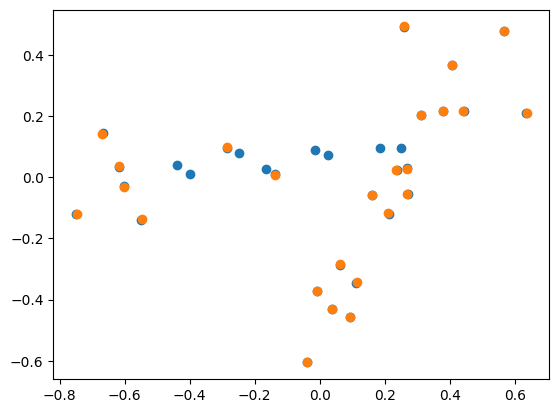

In [82]:
plt.scatter(data.x[:,0],data.x[:,2])
plt.scatter(pts[:,0],pts[:,2])





# Reconstruct Edges

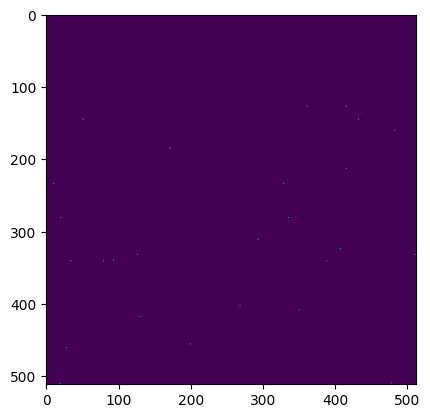

In [83]:
res = minimum_filter(recon_np,footprint=np.ones((11,11,11)))
mask = (recon_np == res)
plt.imshow(mask[:,:,128])

In [84]:
idxx,idxy,idxz = np.nonzero(mask)
vals = recon[idxx,idxy,idxz]
vals /=vals.min()
idx = np.where(vals>.8)

idx_x = idxx[idx]
idx_y = idxy[idx]
idx_z = idxz[idx]

lin = np.linspace(-1,1,NUM_STEPS,endpoint=False)


edge_pts = torch.tensor( np.vstack([lin[idx_x],
lin[idx_y],
lin[idx_z]]).T)

print(vals.sort()[0])


tensor([0.0475, 0.0548, 0.0567,  ..., 0.9639, 0.9946, 1.0000])


In [85]:
ei_true = []
for ei_idx in ei.T:
    # print(ei_idx)
    ei_true.append((x[ei_idx[0]]+x[ei_idx[1]])/2)

ei_true = torch.vstack(ei_true)
print(ei_true)
print(edge_pts)

tensor([[ 4.9806e-02, -4.0591e-01, -3.5749e-01],
        [-6.6809e-04, -4.9738e-01, -5.1751e-01],
        [ 7.5407e-02, -6.1653e-01, -3.8774e-01],
        [ 4.9806e-02, -4.0591e-01, -3.5749e-01],
        [ 2.6942e-02, -2.0030e-01, -3.2870e-01],
        [ 1.1188e-01, -3.1527e-01, -1.7252e-01],
        [ 2.6942e-02, -2.0030e-01, -3.2870e-01],
        [-5.7638e-01,  6.2038e-01, -8.3715e-02],
        [-6.3538e-01,  5.7812e-01,  5.6999e-02],
        [-6.7642e-01,  5.0015e-01, -7.4446e-02],
        [-5.0092e-01,  4.6139e-01, -9.4079e-03],
        [-5.2834e-01,  9.9163e-02,  3.7156e-02],
        [-2.6630e-01, -1.1365e-01,  8.6662e-02],
        [-1.5114e-01,  5.6071e-01,  1.8060e-02],
        [ 4.8735e-01,  1.0593e-01,  4.2234e-01],
        [ 3.3314e-01,  1.3007e-01,  4.2906e-01],
        [ 2.5920e-01,  5.0703e-01,  6.2411e-02],
        [ 2.7433e-01, -5.5644e-01,  1.1305e-01],
        [ 2.4117e-01, -8.3401e-01, -8.7189e-02],
        [ 1.0375e-01, -8.0551e-01, -4.0208e-01],
        [-6.6809e-04

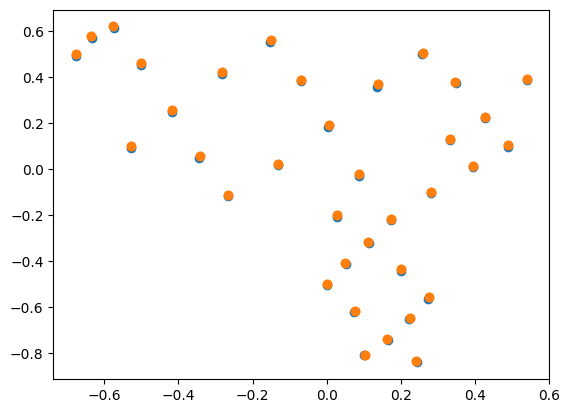

In [86]:
# plt.scatter(pts[:,0],pts[:,1])
plt.scatter(edge_pts[:,0],edge_pts[:,1])
plt.scatter(ei_true[:,0],ei_true[:,1])

In [91]:
print(ei.shape)
print(edge_pts.shape)

torch.Size([2, 70])
torch.Size([35, 3])


In [92]:
adj = np.zeros((len(pts),len(pts)))
ei_recon = []
for i in range(len(pts)):
    for j in range(len(pts)):
        pt_i = pts[i].reshape(1,3)
        pt_j = pts[j].reshape(1,3)
        pt = (pt_i+pt_j )/2
        
        for epts in edge_pts:
            if torch.norm(epts-pt) < .005:
                ei_recon.append([i,j])
        
        # pt.repeat(edge_pts.shape[0],axis=0)-edge_pts
        # print(np.linalg.norm(pt.repeat(edge_pts.shape[0],dim=0)-edge_pts,axis=1).min())
        # if np.linalg.norm(pt.repeat(edge_pts.shape[0],axis=0)-edge_pts,axis=1).min() < .1:
            # print("true")
print(torch.tensor(ei_recon).shape)
print(torch.tensor(ei_recon))

torch.Size([40, 2])
tensor([[ 0,  3],
        [ 1,  3],
        [ 3,  0],
        [ 3,  1],
        [ 3,  4],
        [ 4,  3],
        [ 7,  9],
        [ 8, 10],
        [ 9,  7],
        [ 9, 10],
        [ 9, 12],
        [10,  8],
        [10,  9],
        [10, 13],
        [11, 12],
        [12,  9],
        [12, 11],
        [12, 14],
        [13, 10],
        [13, 15],
        [13, 21],
        [14, 12],
        [14, 15],
        [14, 17],
        [15, 13],
        [15, 14],
        [15, 19],
        [16, 21],
        [17, 14],
        [19, 15],
        [20, 21],
        [21, 13],
        [21, 16],
        [21, 20],
        [21, 22],
        [21, 23],
        [22, 21],
        [22, 24],
        [23, 21],
        [24, 22]])


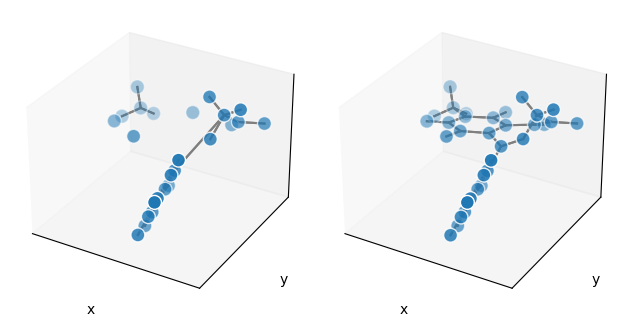

In [93]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The graph to visualize
# G = nx.cycle_graph(20)
# pos = nx.spring_layout(G, dim=3, seed=779)

# 3d spring layout
# Extract node and edge positions from the layout
node_xyz = pts.numpy()

edge_xyz = np.array([(pts[u].numpy(), pts[v].numpy()) for u, v in ei_recon])


# node_xyz = pts
# edge_xyz = np.array(ei_recon).T

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(121, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()

########################################################################
###
########################################################################

ax = fig.add_subplot(122, projection="3d")

node_xyz = data.x.numpy()

edge_xyz = np.array([(node_xyz[u], node_xyz[v]) for u, v in data.edge_index.T])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()


plt.show()

